
# SST-X115

* Predictions of monthly mean SST for the ERA5
* Using a multilayer LSTM network
* Predictions using greedy inference
* Input sequence equal to output sequence -- loss computed on entire sequence
* 1 to 1
* Using new libraries as the Climformer
* Using new time management of forecasts


This notebook yields above persistence result until month 6

In [4]:
import os
import sys
import math
import datetime
import time

import matplotlib.pyplot as plt
# from matplotlib import ticker
# from matplotlib.colors import LogNorm
# from matplotlib.lines import Line2D
# from cartopy.mpl.ticker import LongitudeFormatter

import numpy as np
import scipy.linalg as sc
import scipy.signal as sig
import numpy.linalg as lin


import xarray as xr
import pandas as pd

# import numpy.polynomial.polynomial as poly

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# insert at 1, 0 is the script path (or '' in REPL)
homedir = os.path.expanduser("~")
print('Root Directory for Data ',homedir)
drop_home = '/CMCC Dropbox/Antonio Navarra'
sys.path.insert(1, homedir + drop_home + '/ZapataLibrary/Zapata')


#Working Directory
wkdir =  drop_home + '/AI'
dddir =  drop_home + '/ERA5_DATA'
os.chdir(homedir + wkdir)
print('Working Directory set to ',os.getcwd())


import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import AIModels.AIutil as zai
import AIModels.AIClasses as zaic
import AIModels.ClimLSTM as zcf

import util as ut

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


Root Directory for Data  /Users/antonionavarra
Working Directory set to  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/AI


In [5]:
%%javascript
document.title='AI'

<IPython.core.display.Javascript object>

In [6]:
#optionally print notebook
# jupyter nbconvert SST-X113.ipynb --to pdf

In [7]:
# Configure case

case = 'X115'
shift = 'ERA5'      # Choose data period
SMOOTH = False       # Apply seasonal filter
DETREND = True
period = 'ANN'      # Annual or season
data_name= case 
normalization = 'anom'  #Normalization for the EOF
write_result = False    # Write esults to netcdf file
only_valtrain_eof = True  # Use only training and validation for EOF
verify_dyn = False  #  Verify against dynamical forecasts
choose_device = 'MPS'   # choose if 'CPU' or 'MPS' for M1-2 chips
dataversion = 'V5' #. Could be 'V5'
loc_data = homedir + dddir
# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None # 0.99#.99#.Corsi e Carriere Dottorato di Ricerca <aform.udottricerca@unibo.it>999 #None# Variance retained or None for full rank

  
#Select period for EOF:
if only_valtrain_eof:
    #Use only training and validation for EOF:
    if SMOOTH:
        eof_interval =['1940-03-01','2015-12-01']
    else:
        eof_interval =['1940-01-01','2015-12-01']
else:
    eof_interval = None   # Use all data

#Select variables:
SST = zaic.Field('SST',['SST'],'TROPIC',25)
InputVars = [SST]
PredictVars = [SST]

# Define identifiers and configuration for network

In [9]:
# Write case configuration
caseid =  {'case':case, 'version':dataversion, 'SMOOTH':SMOOTH, 'detrend':DETREND, 'normalization':normalization, 'only_valtrain_eof':only_valtrain_eof, 'eof_interval':eof_interval,\
                   'shift':shift,'period':period, 'InputVars':InputVars,'PredictVars':PredictVars}

params ={'TIN':1,'MIN':25,'T':1,'K':25,'EPOCHS':500,'scaling':'STD','RESTART':False, 
         'HID_DIM':512, 'Tpredict':12, 'N_LAYERS':1,
         'FFN_DIM':64,'ENC_Heads':8,'DEC_Heads':8, 
         'LR':0.0005,'WD':0.05,'savefile':None}
params['savefile'] = f"LSTM_{case}_SST_{normalization}_{SST.area}_{params['HID_DIM']}_{params['TIN']}.pt"

In [10]:
#Input variables data base
invar_dict = {'period':'ANN', 'version':dataversion, 'SMOOTH':SMOOTH, 'detrend':DETREND, 'normalization':normalization, \
              'eof_interval':eof_interval, 'shift':'ERA5', 'case':case, 'datatype':'Source_data','location':loc_data}
INX=zai.make_data_base(InputVars, **invar_dict)

Directory  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5_DATA/DATA_CACHE  Already Exists
Selected data from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000 

Use Pacific centered coordinates with centlat=180
Selecting field SST for level SST and area TROPIC
{'dropnan': False, 'detrend': True}
Created data Matrix X, stacked along dimensions ('lat', 'lon') 
Option DropNaN False -- Shape of Xmat (298511, 996)
make_matrix: -- Detrending data
Detrending data with options -->  {'axis': 1}
EOF interval defined -- Using data from 1940-01-01 to 2015-12-01
make_eof: -- EOF interval defined -- Using data from 1940-01-01 to 2015-12-01
make_eof: -- EOF interval defined -- Using data from 0 to 911
  Number of SVD modes retained 25, rank of matrix 213
Variance Retained 0.72 out of possible 911 modes
 Condition number 254.41610717773438
Added field `SST` with identification `SSTSST` to data base


In [11]:
#Predicted variables data base
pred_dict = {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, \
                   'shift':'ERA5', 'case':case, 'datatype':'Target_data','location':loc_data}
#Save space
# PDX=zai.make_data_base(PredictVars, **pred_dict)
PDX = INX

In [12]:
#Verification variables data base
# SSTver = zaic.Field('SST',['SST'],'TROPIC',math.inf)

# ver_dict = {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, \
#                    'shift':'ERA5', 'case':case, 'datatype':'Target_data','location':homedir+dddir}
# #Save space
# VEX=zai.make_data_base([SSTver], **ver_dict)
area = INX['SSTSST']['area']

TIN = params['TIN']  # Number of input timesteps
MIN = params['MIN']   # Number of input features
T = params['T']    # Number of optimization targets timesteps
K = params['K']    # Number of predicted features
num_epochs = params['EPOCHS'] 
N_LAYERS = params['N_LAYERS']
learning_rate = params['LR'] 
HID_DIM = params['HID_DIM']  # Hidden DImension
Tpredict = params['Tpredict']  # Number of predicted timesteps

file = params['savefile']

In [13]:
# Obtain time dates from data chosen
field1 = list(INX.keys())[0]
fd = INX[field1]['X'].A.time.data[0]
fl = INX[field1]['X'].A.time.data[-1]
pd.Timestamp(fd), pd.Timestamp(fl)
data_time = pd.date_range(start=fd, end=fl, freq='1MS')
data_time_str = data_time.strftime('%Y-%m-%d')


# Time variables

The time variables are grouped in two sets:

    - start_date = ...
    - end_training = ... 
    - start_val = '2006-01-01'
    - end_val = '2015-12-01'
    - test_start = '2016-01-01'
    - test_end = '2022-12-01'

contains the limit of training, validation and test in `date` format.

    - train_period_start
    - train_period_end 
    - val_period_start 
    - val_period_end 
    - test_period_start
    - test_period_end 

contains the index into the data computed by `make_data_base`.  The last index `test_period_end` is 
pointing to the last forecast month so that verification can be done until the end of the data test period.

The variables are then added to the dict `params`

In [15]:
# data_time.get_loc(fd)
Tpredict = params['Tpredict']

match dataversion:
    case 'V5':
        start_date = data_time_str[0]
        end_training = '2005-12-01'

        start_val = '2006-01-01'
        end_val = '2015-12-01'

        test_start = '2016-01-01'
        test_end = '2022-12-01'
    case 'HAD':
        start_date = data_time_str[0]
        end_training = '1979-12-01'

        start_val = '1980-01-01'
        end_val = '1999-12-01'

        test_start = '2000-01-01'
        test_end = '2020-12-01'

print(f'Training \tfrom \t{start_date} \tto \t{end_training}')
print(f'Validation \tfrom \t{start_val} \tto \t{end_val}')
print(f'Testing \tfrom \t{test_start} \tto \t{test_end}\n')

train_period_start = data_time.get_loc(start_date)
train_period_end = data_time.get_loc(end_training)
val_period_start = data_time.get_loc(start_val)
val_period_end = data_time.get_loc(end_val)
test_period_start = data_time.get_loc(test_start)
test_period_end = data_time.get_loc(test_end)

#Correct for last forecast to be in verification period
test_period_end = test_period_end - Tpredict +1

print(f'Indices for \nTraining \t{train_period_start}\tto \t{train_period_end}\nValidation \t{val_period_start}\tto \t{val_period_end}\nTest \t\t{test_period_start}\tto \t{test_period_end}\n')

print(f'Data Extent in Training {(train_period_end-train_period_start+1)}')
print(f'Data Extent in Validation {(val_period_end-val_period_start+1)}')
print(f'Number of Forecasts in test period  {(test_period_end-test_period_start)}')

params |= {'start_date':start_date,'end_training':end_training, 'start_val':start_val,'end_val':end_val,'test_start':test_start,'test_end':test_end, \
        'train_period_start':train_period_start,'train_period_end':train_period_end, 'val_period_start':val_period_start, 'val_period_end':val_period_end,'test_period_start':test_period_start, 'test_period_end':test_period_end}

# Define range indices for forecasting sequences
params['train_first_fcs'] = TIN                           # First forecasted month for first forecast 
params['train_last_fcs'] = params['train_period_end'] - Tpredict   +2     # First forecasted month for last forecast 
params['val_first_fcs'] = params['val_period_start']  + TIN    
params['val_last_fcs'] = params['val_period_end'] - Tpredict    +2    
params['test_first_fcs'] = params['test_period_start']  + TIN
params['test_last_fcs'] = params['test_period_end'] - Tpredict    +2   
print(f'Starting indices for the sequences in training and forecasts\n')
print(f"TESTING -- \tFirst forecasted month for first forecast {params['test_first_fcs']}\n\tFirst forecasted month for last forecast {params['test_last_fcs']}")
print(f"TRAINING -- \tFirst forecasted month for first forecast {TIN}\n\tFirst forecasted month for last forecast {params['train_last_fcs']  }")

print(f'Number of forecast cases in each epoch')
print(f"Forecast in Training {params['train_last_fcs']-params['train_first_fcs'] }")
print(f"Forecast in Validation {params['val_last_fcs']-params['val_first_fcs'] }")
print(f"Forecast in Test {params['test_last_fcs']-params['test_first_fcs'] }")

Training 	from 	1940-01-01 	to 	2005-12-01
Validation 	from 	2006-01-01 	to 	2015-12-01
Testing 	from 	2016-01-01 	to 	2022-12-01

Indices for 
Training 	0	to 	791
Validation 	792	to 	911
Test 		912	to 	984

Data Extent in Training 792
Data Extent in Validation 120
Number of Forecasts in test period  72
Starting indices for the sequences in training and forecasts

TESTING -- 	First forecasted month for first forecast 913
	First forecasted month for last forecast 974
TRAINING -- 	First forecasted month for first forecast 1
	First forecasted month for last forecast 781
Number of forecast cases in each epoch
Forecast in Training 780
Forecast in Validation 108
Forecast in Test 61


## Plot Input Data

 Opening figure , 1 rows and 1 cols 

Ten Contours automatic


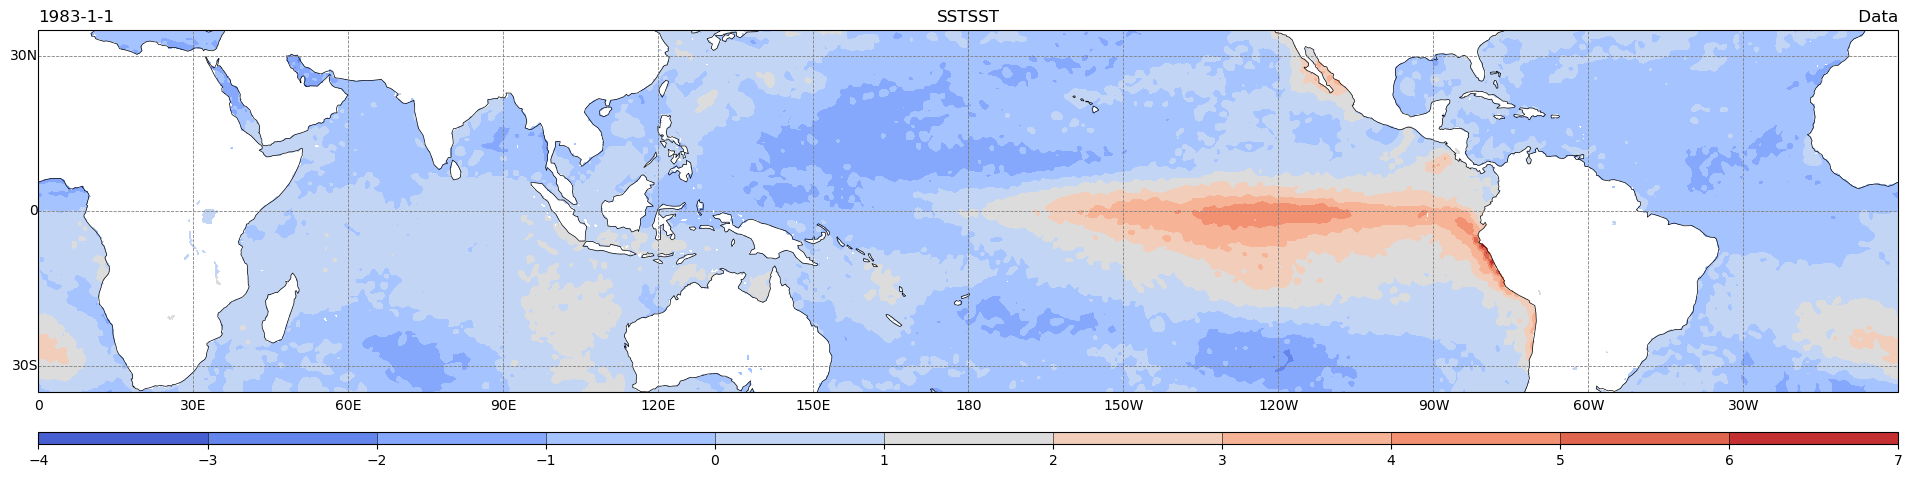

In [17]:
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[]
cont2=[]
cont3=[]
label1 = ' Data'
label2 = '1983-1-1'
label3 = '1998-1-1'
    
fig,ax,pro=zmap.init_figure(len(INX.keys()),1,'Pacific', constrained_layout=False, figsize=(24,12) )
for i in enumerate(INX.keys()):
    X,arealat,arealon,centlon = zai.select_field(INX,i[1])
    # "x is greater" if x > y else "y is greater"
    axm = ax if len(INX.keys()) < 2  else ax[i[0]]
    handle=zmap.xmap(X.A.sel(time=label2).unstack(),cont1, pro, ax=axm,refline=None, c_format='{:4.2f}',data_cent_lon=centlon,\
                 xlimit=(arealon[0],arealon[1]), ylimit=(arealat[1],arealat[0]),
                 title={'maintitle':i[1], 'lefttitle':label2,'righttitle':label1},cmap='coolwarm',contour=False)
    zmap.add_colorbar(fig, handle['filled'], axm, label_size=10,edges=True)
fig.subplots_adjust(wspace=0.1,hspace=0.3)
labfile =  f'{data_name}SST{period}.pdf'
plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()

In [18]:
# area = INX['SSTSST']['area']

# TIN = params['TIN']  # Number of input timesteps
# MIN = params['MIN']   # Number of input features
# T = params['T']    # Number of optimization targets timesteps
# K = params['K']    # Number of predicted features
# num_epochs = params['EPOCHS'] 
# N_LAYERS = params['N_LAYERS']
# learning_rate = params['LR'] 
# HID_DIM = params['HID_DIM']  # Hidden DImension
# Tpredict = params['Tpredict']  # Number of predicted timesteps

# file = params['savefile']
batch_size = 64
torch.manual_seed(17553984)


INPUT_DIM = MIN
OUTPUT_DIM = K

match choose_device:
    case 'CPU':
        device = torch.device('cpu')
        t_type = torch.float32
    case 'MPS':
        device = torch.device('mps')
        t_type = torch.float32
    case _:
        device = torch.device('cpu')
        t_type = torch.float32
torch.set_default_dtype(t_type)
params['device'] = device
params['t_type'] = t_type

# Data preparation
# data = vdat.T # Your timeseries dataset of shape (N, M)
# The scaling is done on the training set and the same scaling is apllied to the test data..
data_tr, data_va, data_te, _ = zai.make_data(INX,params)

# Split the dataset into train, validation, and test sets
train_size = (train_period_end-train_period_start+1)
val_size = (val_period_end-val_period_start+1)
test_size = (test_period_end-test_period_start+1)

tot_size = (test_period_end-train_period_start+1)
print(f'Train {train_size}, Validation {val_size}, Test {test_size}')
print(f'Check {train_size+val_size+test_size} <---> {tot_size}')

# Split the data into train, validation, and test sets
train_data = torch.tensor(data_tr,device=device,dtype=t_type) # normalize
val_data = torch.tensor(data_va,device=device,dtype=t_type) # normalize
test_data = torch.tensor(data_te,device=device,dtype=t_type) # normalize
print(f'\nTensors Train {train_data.shape}, Validation {val_data.shape}, Test {test_data.shape}')
print(f'Check Tensors {train_data.shape[0]+val_data.shape[0]+test_data.shape[0]}')



Processing field SST that is Source_data
select_field_eof ---> Extracting EOF data for SST
vdat (25, 996)
Added field SSTSST to feature input data
Index for field SST are 0 and 25

Using STD scaling
Using  25  EOFs for 0.7198782368613535 variance retained
Training data shape torch.Size([792, 25])
Validation data shape torch.Size([120, 25])
Testing data shape torch.Size([73, 25])
Train 792, Validation 120, Test 73
Check 985 <---> 985

Tensors Train torch.Size([792, 25]), Validation torch.Size([120, 25]), Test torch.Size([73, 25])
Check Tensors 985


In [19]:
# Create instances of the custom dataset for train, validation, and test
train_dataset = zcf.TimeSeriesDataset(train_data,  TIN, MIN, T, K)
val_dataset = zcf.TimeSeriesDataset(val_data,  TIN, MIN, T, K)
test_dataset = zcf.TimeSeriesDataset(test_data, TIN, MIN, T, K)

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset,  batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,  batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [20]:
len(test_dataloader.dataset)

72

In [21]:
patience = 10

model = zcf.ClimLSTM(OUTPUT_DIM, INPUT_DIM, HID_DIM, N_LAYERS)

#Initialize weights
if params['RESTART']:
    model.load_state_dict(torch.load('X11.pt'))
else:
    model.apply(zai.init_weights)

#Number of parameters
print(f'The model has {zai.count_parameters(model):,} trainable parameters')

#Optimizer
# optimizer = optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=params['WD'],amsgrad=True)
optimizer = optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=params['WD'],amsgrad=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, mode="min", verbose=True)

early_stopping = zaic.EarlyStopping(patience=3*patience,verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, mode="min", verbose=True)    
criterion= nn.L1Loss()


The model has 1,116,697 trainable parameters


In [22]:
CLIP = 1


best_valid_loss = float('inf')

lossval =[]
losstr = []

model.to(device) 

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss = model.train_model( train_dataloader, optimizer, criterion, scheduler, CLIP, device)
    valid_loss = model.evaluate_model( val_dataloader, criterion, device)
    
    lossval.append(valid_loss)
    losstr.append(train_loss)

    end_time = time.time()
    
    epoch_mins, epoch_secs = zai.epoch_time(start_time, end_time)
    
    # Early stopping
   
    if early_stopping(valid_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

    if valid_loss < best_valid_loss and epoch % 5 == 0 :
        best_valid_loss = valid_loss
        print(f"Saving model at {best_valid_loss} as {'X11.pt'}")
        torch.save(model.state_dict(), 'X11.pt')

    if epoch % 5 == 0:
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')



Saving model at 0.7707414329051971 as X11.pt
Epoch: 01 | Time: 0m 2s
	Train Loss: 0.789 | Valid Loss: 0.771
Saving model at 0.6905930042266846 as X11.pt
Epoch: 06 | Time: 0m 0s
	Train Loss: 0.681 | Valid Loss: 0.691
Saving model at 0.6122539043426514 as X11.pt
Epoch: 11 | Time: 0m 0s
	Train Loss: 0.577 | Valid Loss: 0.612
Saving model at 0.551304966211319 as X11.pt
Epoch: 16 | Time: 0m 0s
	Train Loss: 0.506 | Valid Loss: 0.551
Saving model at 0.5261605083942413 as X11.pt
Epoch: 21 | Time: 0m 0s
	Train Loss: 0.481 | Valid Loss: 0.526
Saving model at 0.5176922082901001 as X11.pt
Epoch: 26 | Time: 0m 0s
	Train Loss: 0.471 | Valid Loss: 0.518
Saving model at 0.5147785246372223 as X11.pt
Epoch: 31 | Time: 0m 0s
	Train Loss: 0.464 | Valid Loss: 0.515
Saving model at 0.5142215490341187 as X11.pt
Epoch: 36 | Time: 0m 0s
	Train Loss: 0.458 | Valid Loss: 0.514
Epoch: 41 | Time: 0m 0s
	Train Loss: 0.452 | Valid Loss: 0.514
Epoch: 46 | Time: 0m 0s
	Train Loss: 0.446 | Valid Loss: 0.515
Epoch: 51 |

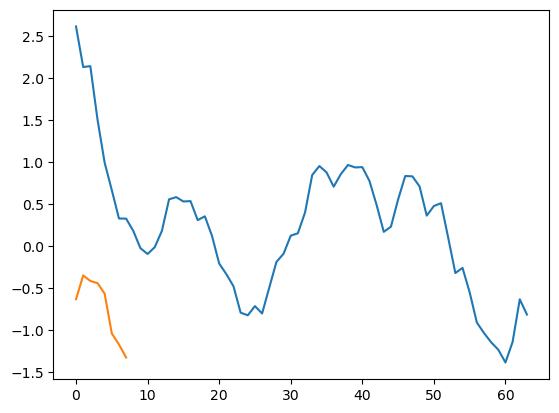

In [23]:
for n,(a,b) in enumerate(test_dataloader):
    plt.plot(a.cpu()[:,0,0])

In [24]:
#Creates Plots

model.load_state_dict(torch.load('X11.pt'))

out_test = model.predict( test_dataloader, K,Tpredict,device)
out_val = model.predict( val_dataloader, K,Tpredict,device)
out_train = model.predict( train_dataloader, K,Tpredict,device)

out_train_p, out_val_p, out_test_p, truep = zai.rescale(params, PDX, out_train, out_val, out_test)

print(f'Shape of prediction tensors Train -- {out_train.shape}, Val -- {out_val.shape}, Test --  {out_test.shape}')




Processing field SST that is Source_data
Number of modes retained 25
(996, 25)
Shape of prediction tensors Train -- (791, 12, 25), Val -- (119, 12, 25), Test --  (72, 12, 25)


In [25]:
# plt.plot(out_test_p[:,0,0])


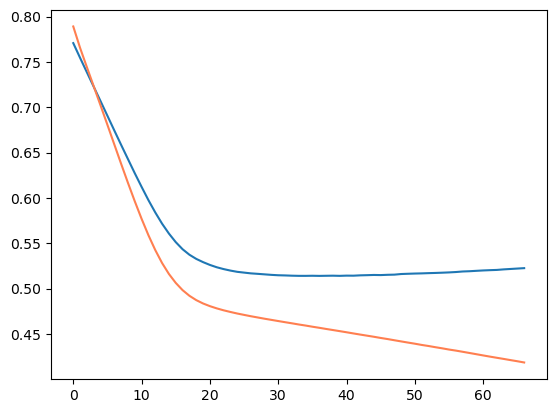

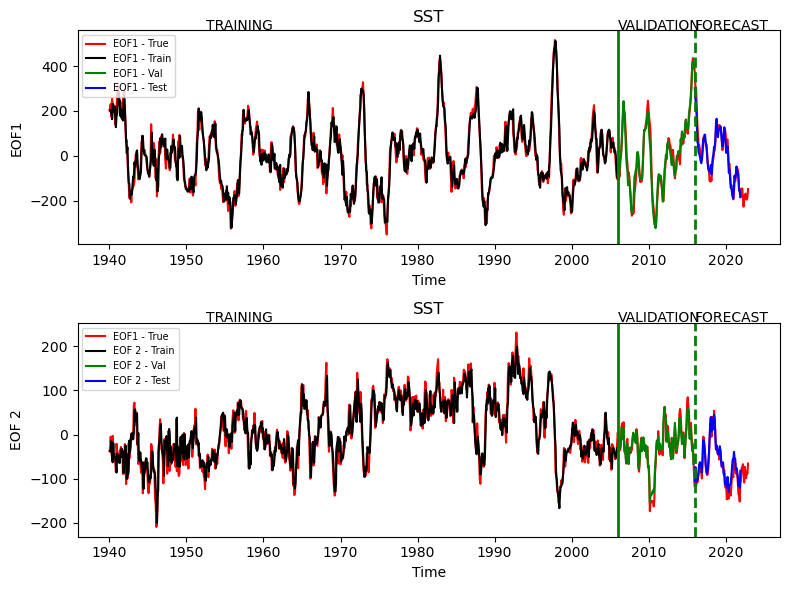

In [26]:
plt.plot(lossval)
plt.plot(losstr,color='coral')
plt.show()

# if SMOOTH:
#     sdate = datetime.date(1870,2,1)   # start date
#     edate = datetime.date(2020,12,1)
# else:
#     sdate = datetime.date(1870,1,1)   # start date
#     edate = datetime.date(2021,1,1)

# times = pd.date_range(sdate,edate,freq='m')
times = data_time

startval = train_size + TIN -1
endval = train_size + val_size  - T
starttest = train_size + val_size + TIN - 1 
endtest = starttest+len(out_test)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the first subplot
#Shift to align the predictions
neof=0
leof = 'EOF1'
tit ='SST'
monpred = 0 
def plot_result(ax1,out_train,out_val,out_test,neof,monpred,leof,tit,truep):
    ax1.plot(times,truep[:,neof], color='red', label='EOF1 - True')
    ax1.plot(times[TIN:len(out_train)+TIN],out_train[:,monpred,neof], color='black', label=leof +' - Train')
    ax1.plot(times[startval:endval],out_val[:,monpred,neof], color='green', label=leof +' - Val')
    ax1.plot(times[starttest:endtest],out_test[:,monpred,neof], color='blue', label=leof +' - Test')
    # ax1.set_xlim(times[1500],times[1600]
    ax1.set_xlabel('Time')
    ax1.set_ylabel(leof)
    ax1.set_title(tit)
    ax1.axvline(times[train_size],color='green',lw=2.0)
    ax1.axvline(times[train_size+val_size],color='green',lw=2.0,linestyle='dashed')
    _, yt = ax1.get_ylim()
    ax1.text(times[150],yt+1,'TRAINING')
    ax1.text(times[train_size],yt+1,'VALIDATION')
    ax1.text(times[train_size + val_size],yt+1,'FORECAST')

    ax1.legend(loc='upper left',fontsize='x-small')
plot_result(ax1,out_train_p,out_val_p,out_test_p,neof,monpred,leof,tit,truep)
plot_result(ax2,out_train_p,out_val_p,out_test_p,1,monpred,'EOF 2',tit,truep)

# Adjust the layout to avoid overlapping labels and titles
plt.tight_layout()

# Display the figure
plt.show()


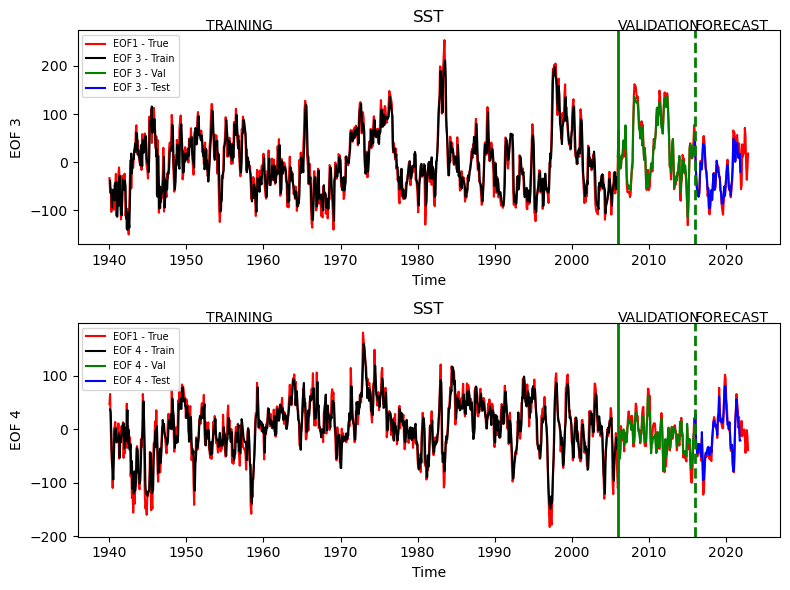

In [27]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_result(ax1,out_train_p,out_val_p,out_test_p,2,monpred,'EOF 3',tit,truep)
plot_result(ax2,out_train_p,out_val_p,out_test_p,3,monpred,'EOF 4',tit,truep)
# Adjust the layout to avoid overlapping labels and titles
plt.tight_layout()

# Display the figure
plt.show()


In [28]:
F, V, P, Obs = zai.eof_to_grid_new('test','SSTSST', truep, out_test_p, times, INX=PDX, params=params, truncation=None)


Verification using entire field (298511, 996))
Persistence using entire field (298511, 996)
Obs from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000

 Number of cases 61
Observation selected for test 
 
Obs from 2016-02-01T00:00:00.000000000 to 2021-03-01T00:00:00.000000000

Verification for first forecast at 913 to 974
Verification time for `test` from first month forecast 2016-02-01T00:00:00.000000000 to 2021-03-01T00:00:00.000000000
Tmp shape (61, 13, 298511), 2016-01-01T00:00:00.000000000 to 2021-01-01T00:00:00.000000000
Verification shape (61, 13, 298511), 2016-01-01T00:00:00.000000000 to 2021-01-01T00:00:00.000000000
Forecast shape (61, 13, 298511), 2016-01-01T00:00:00.000000000 to 2021-01-01T00:00:00.000000000
Persistence shape (61, 13, 298511), 2016-01-01T00:00:00.000000000 to 2021-01-01T00:00:00.000000000


In [29]:
# Compute correlation
# For each day

ERROR = 'L2'
Np, _, _ = F.shape

corrresult = np.zeros((Tpredict+1,Np))
persistence = np.zeros((Tpredict+1,Np))

rmsres = np.zeros((Tpredict+1,Np))
rmsper = np.zeros((Tpredict+1,Np))

# totday,totfor = corrresult.shape

ictime = Obs.time
starttest = params['test_period_start'] 

for iday in range(Tpredict+1):
    this_day = ictime[starttest+1+iday:starttest+iday+Np+1]
    Fp = F[:,iday,:].assign_coords({'time':this_day.data})
    Vp = V[:,iday,:].assign_coords({'time':this_day.data})
    Pp = P[:,iday,:].assign_coords({'time':this_day.data})
    corrresult[iday,:]= xr.corr(Fp,Vp, dim='z').data
    persistence[iday,:]= xr.corr(Pp,Vp, dim='z').data
    if verify_dyn:
        dyn = np.mean(corrdyn,axis=1)  # Start from month 1
    
    NumPoints = F.shape[2]
    if ERROR == 'L1':
        rmsresi[iday,:]= np.sum(abs(Fp - Vp),axis=2).data/NumPoints
        rmsper[iday,:]= np.sum(abs(Pp - Vp),axis=2).data/NumPoints
    else:
        rmsres[iday,:]= np.sqrt(np.sum((Fp - Vp)**2,axis=1).data)/NumPoints
        rmsper[iday,:]= np.sqrt(np.sum((Pp - Vp)**2,axis=1).data)/NumPoints


In [30]:
# 
plfield = 'SSTSST'
starttest = params['test_period_start']  + TIN
endtest = starttest + Np - 1

figarea = INX[plfield]['area']
figinfield = [i for i in INX.keys()]
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={N_LAYERS}"

# fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 8))

# for i in range(1,Tpredict,5):
#     hl, = ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
#     ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Pers {i}',linestyle='dashed',color=hl.get_color())
# ax1.set_ylim(-0.4,1.2)
# ax1.set_title(f'Skill Score {plfield} in {figarea}',loc='left')
# ax1.set_title(idfig,loc='right',fontsize=8)

# ax1.legend()

    
# tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
# ax3.bar(np.arange(1,Tpredict+1),tw)
# ax3.set_title('Number of forecasts above 0.6')
# ax3.set_xlabel('Lead Months')
# # plt.savefig('Bar'+idfig+'.pdf')
# plt.show()

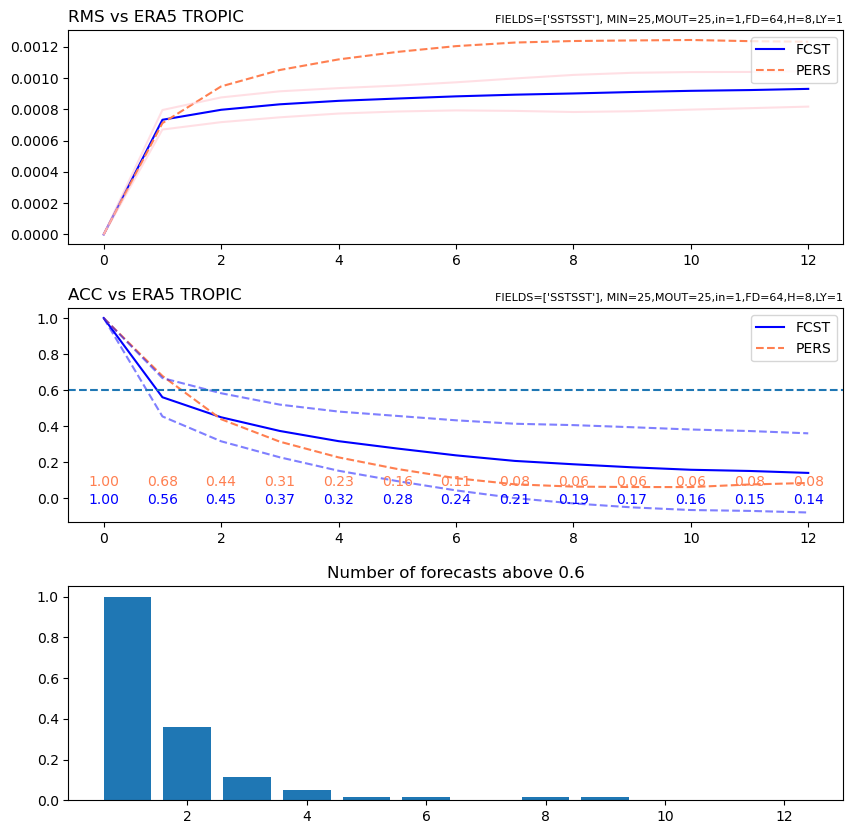

In [31]:
# Mean
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 1, width_ratios=[0.5], height_ratios=3*[1], wspace=0.3, hspace=0.3)

# Left panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])



sk = np.mean(corrresult,axis=1)
skstd = np.std(corrresult,axis=1)
ps = np.mean(persistence,axis=1)

if verify_dyn:
    dyn = np.mean(corrdyn,axis=1)  # Start from month 1
    dystd = np.std(corrdyn,axis=1)

tim = np.arange(0,Tpredict+1)
# print(tim.shape,sk.shape)
ax2.plot(tim, sk,label='FCST',color='blue')
ax2.plot(tim, ps,linestyle='dashed',color='coral',label='PERS')
if verify_dyn:
    ax2.plot(tim[1:7], dyn,linestyle='dashed',color='lightgreen',label='DYN')

ax2.plot(tim,sk+skstd,color='blue',alpha=0.5,linestyle='dashed')
ax2.plot(tim,sk-skstd,color='blue',alpha=0.5,linestyle='dashed')
# ax2.plot(tim[:-1],(dyn+dystd)[1:],color='lightgreen',alpha=0.5)
# ax2.plot(tim[:-1],(dyn-dystd)[1:],color='lightgreen',alpha=0.5)


ax2.axhline(0.6,linestyle='dashed')
ax2.set_title(f'ACC vs ERA5 {figarea}',loc='left')
ax2.set_title(idfig,loc='right',fontsize=8)
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center',color='blue')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
ax2.legend(loc='upper right')
# ax2.set_xlim(1,7)    

sk = np.mean(rmsres,axis=1)
skstd = np.std(rmsres,axis=1)
ps = np.mean(rmsper,axis=1)



if verify_dyn:
    rdyn = np.mean(rmsdyn,axis=1)
    ax1.plot(tim[1:7], rdyn,label='DYN',color='lightgreen')
ax1.plot(tim, sk,label='FCST',color='blue')
ax1.plot(tim,ps,linestyle='dashed',color='coral',label='PERS')

ax1.plot(tim,sk+skstd,color='pink',alpha=0.5)
ax1.plot(tim,sk-skstd,color='pink',alpha=0.5)

ax1.set_title(f'RMS vs ERA5 {figarea}',loc='left')
ax1.set_title(idfig,loc='right',fontsize=8)

ax1.legend(loc='upper right')

tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')

# plt.savefig('Skill'+idfig +'.pdf')
plt.show()

In [32]:
skill = 'median' #'mean'

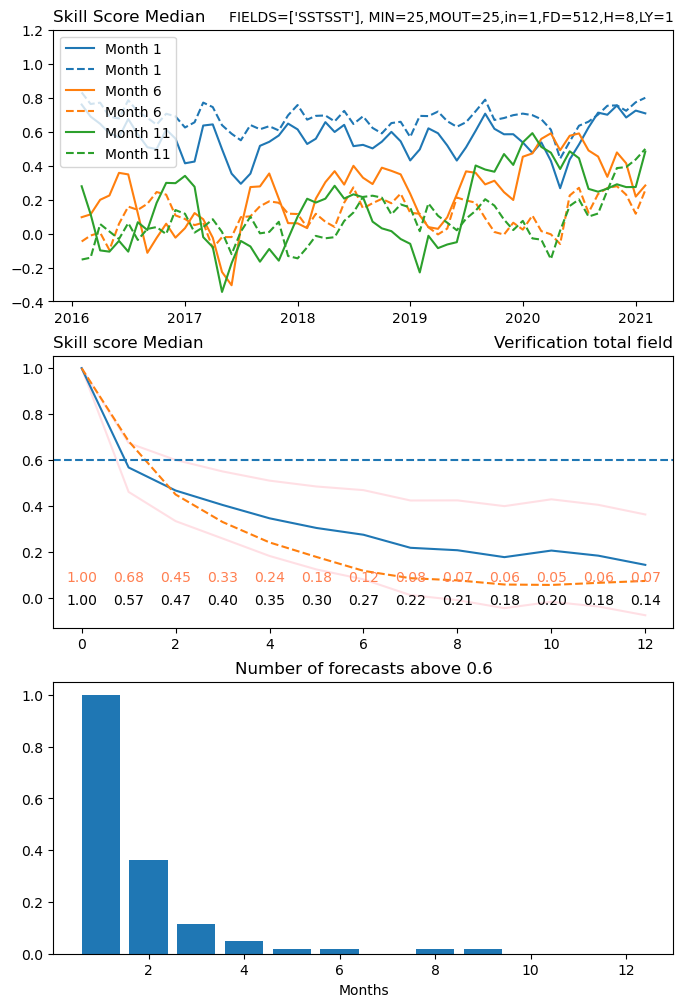

In [33]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 12))

for i in range(1,Tpredict,5):
    hl,=ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Month {i}',color=hl.get_color(), linestyle='dashed')
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['HID_DIM']},H={params['ENC_Heads']},LY={N_LAYERS}"
    
ax1.set_ylim(-0.4,1.2)
ax1.set_title('Skill Score Median',loc='left')
ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

tim = np.arange(0,Tpredict+1)

match skill:
    case 'mean':
        sk = np.mean(corrresult,axis=1)
        ps = np.mean(persistence,axis=1)
        if verify_dyn:
            dyn = np.mean(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,corrresult.mean(axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,corrresult.mean(axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case 'median':
        sk = np.median(corrresult,axis=1)
        ps = np.median(persistence,axis=1)
        if verify_dyn:
            dyn = np.median(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,np.median(corrresult,axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,np.median(corrresult,axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case _:
        raise ValueError('Invalid skill choice')
ax2.plot(tim,sk)
ax2.plot(tim,ps,linestyle='dashed')
if verify_dyn:
    ax2.plot(tim[1:7],dyn,linestyle='dashed',color='green')
        
ax2.axhline(0.6,linestyle='dashed')
ax2.set_title('Skill score Median',loc='left')
ax2.set_title('Verification total field',loc='right')
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
    
tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')
ax3.set_xlabel('Months')
plt.savefig(f'FIG_{file}_{skill}.pdf')
plt.show()

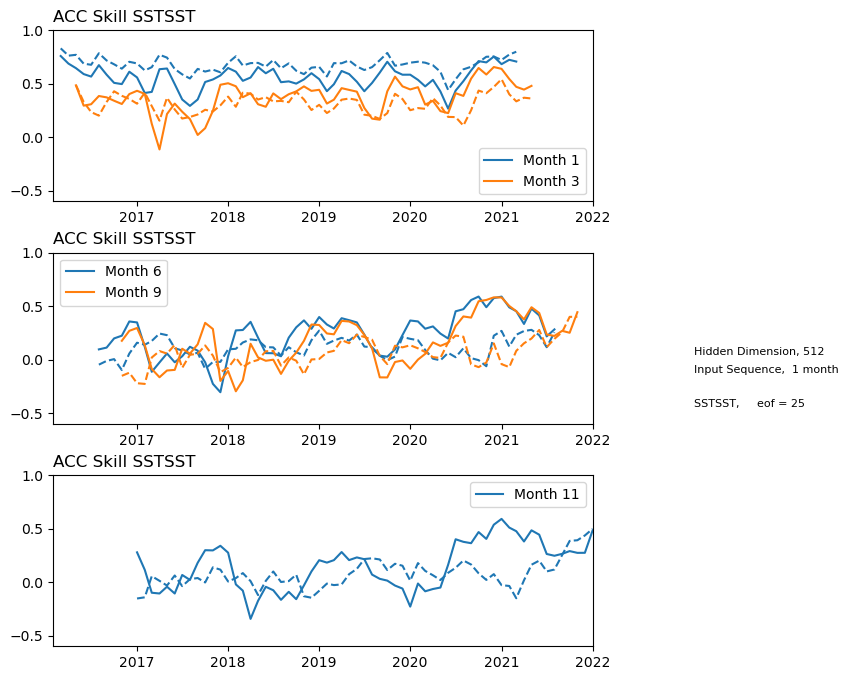

In [34]:
#Figure for forecast

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 2, width_ratios=[4, 1], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)

# Left panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Right panel, aligned with the middle left panel
ax4 = fig.add_subplot(gs[1, 1])

tit = f'ACC Skill {plfield}'
if_time = [1,3]
col = ['black','red','lightblue', 'blue','green']

for i in if_time:
    hl,=ax1.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax1.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax1.set_ylim(-0.6,1.0)
ax1.set_title(tit,loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

if_time = [6,9]
for i in if_time:
    hl,=ax2.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax2.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax2.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax2.set_ylim(-0.6,1.0)
ax2.set_title(tit,loc='left')
# ax2.set_title(idfig,loc='right',fontsize=10)
ax2.legend()

if_time = [11]
for i in if_time:
    hl,=ax3.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax3.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax3.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax3.set_ylim(-0.6,1.0)
ax3.set_title(tit,loc='left')
# ax3.set_title(idfig,loc='right',fontsize=10)
ax3.legend()

# Remove the axis and labels for ax4
ax4.axis('off')  # This removes the axis lines and ticks
ax4.set_xticklabels([])  # This removes the x-axis labels
ax4.set_yticklabels([])  # This removes the y-axis labels

# Label the experiment
dfig = f"Predictors={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={N_LAYERS}"
delta = 0.0
ffcol = {'fontsize':8, 'color':'black'}
for ff in INX.keys():
    lab = f"{ff},     eof = {INX[ff]['mr']}"
    ax4.text(0, 0.1+delta, lab, **ffcol) 
    delta += 0.1
ax4.text(0, 0.3, f'Input Sequence,  {TIN} month', **ffcol) 
ax4.text(0, 0.4, f"Hidden Dimension, {params['HID_DIM']}", **ffcol) 

# Adjust layout
plt.tight_layout()
plt.show()

 Opening figure , 2 rows and 1 cols 

Setting Fixed Contours
 Contouring from  -3.0   to 3.0  with interval   0.5
Setting Fixed Contours
 Contouring from  -3.0   to 3.0  with interval   0.5


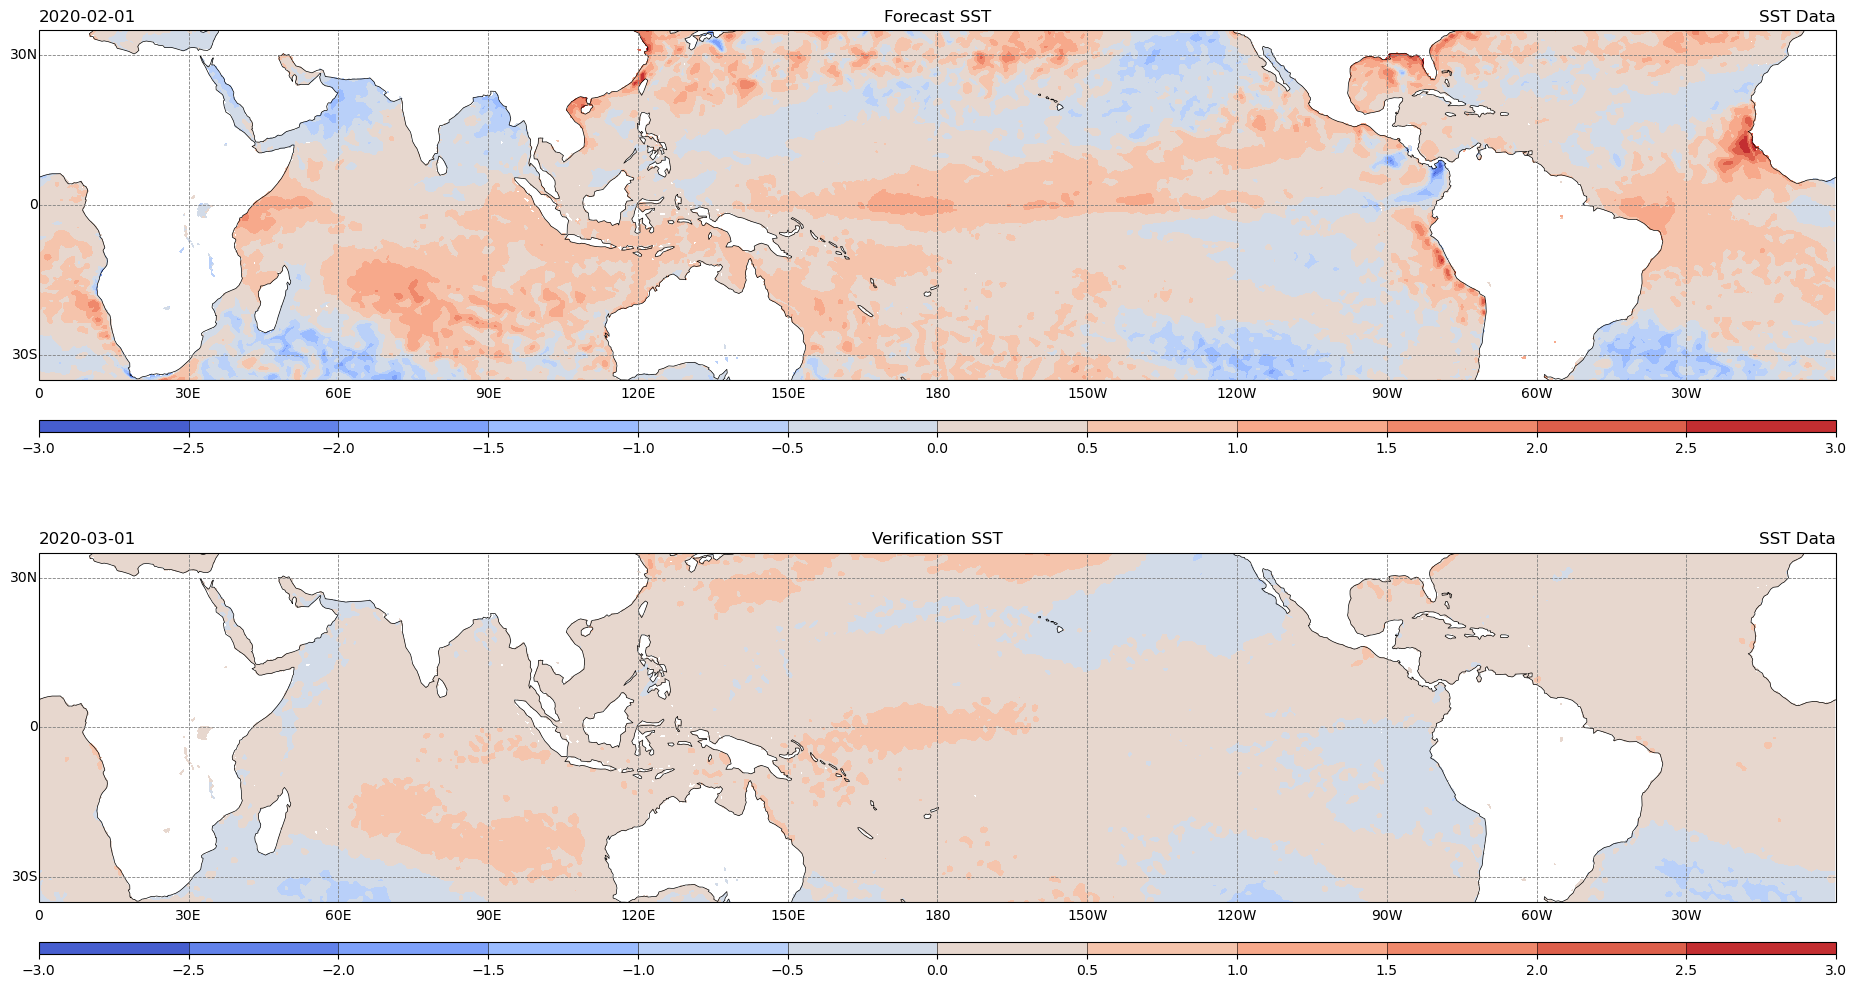

In [35]:
slim=3.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
# cont1=[]
# cont2=[]
i = 10
label1 = 'SST Data'
label2 = '2020-02-01'
label3 = '2020-03-01'
fig,ax,pro=zmap.init_figure(2,1,'Pacific', constrained_layout=False, figsize=(24,12) )
handle=zmap.xmap(V.sel(time=label2,lead=1).unstack(),cont1, pro, ax=ax[0],refline=None, c_format='{:4.2f}',data_cent_lon=180,\
                       title={'maintitle':'Forecast SST', 'lefttitle':label2,'righttitle':label1},cmap='coolwarm',xlimit=arealon,ylimit=(arealat[1],arealat[0]),contour=False)
zmap.add_colorbar(fig, handle['filled'], ax[0], label_size=10,edges=True)
han1=zmap.xmap(F.sel(time=label3,lead=1).unstack(), cont2, pro, ax=ax[1], refline=None,c_format='{:4.2f}',data_cent_lon=180,\
                       title={'maintitle':'Verification SST', 'lefttitle':label3,'righttitle':label1},cmap='coolwarm',xlimit=arealon,ylimit=(arealat[1],arealat[0]),contour=False)
zmap.add_colorbar(fig, han1['filled'], ax[1],label_size=10,edges=True)
fig.subplots_adjust(wspace=0.1,hspace=0.3)
labfile =  f'{data_name}SST{period}.pdf'
# plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()

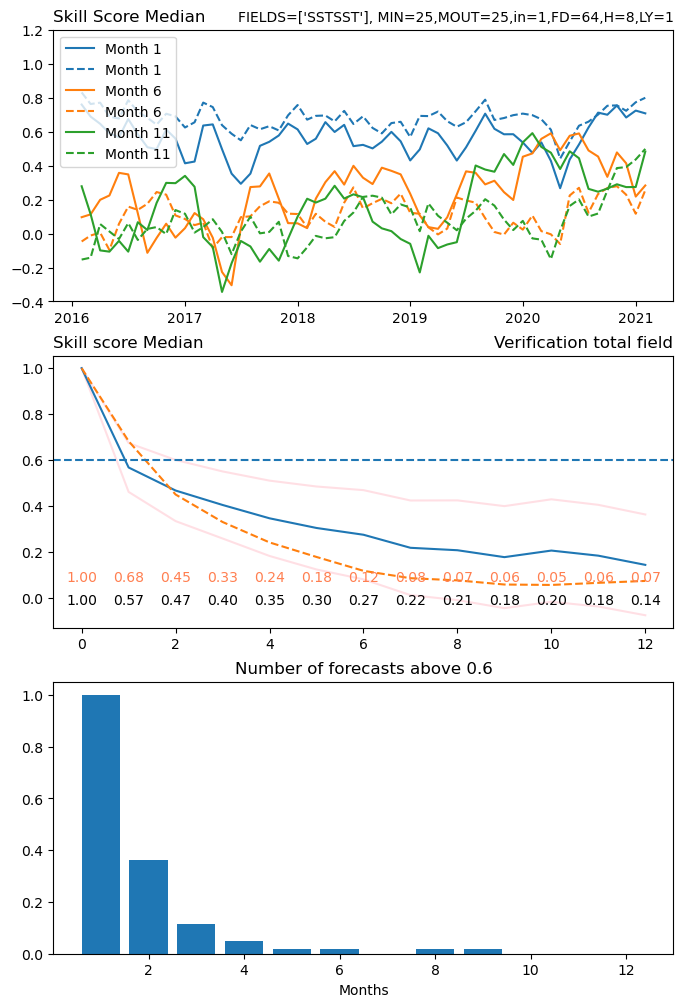

In [36]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 12))

for i in range(1,Tpredict,5):
    hl,=ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Month {i}',color=hl.get_color(), linestyle='dashed')
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={params['N_LAYERS']}"
    
ax1.set_ylim(-0.4,1.2)
ax1.set_title('Skill Score Median',loc='left')
ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

tim = np.arange(0,Tpredict+1)

match skill:
    case 'mean':
        sk = np.mean(corrresult,axis=1)
        ps = np.mean(persistence,axis=1)
        if verify_dyn:
            dyn = np.mean(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,corrresult.mean(axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,corrresult.mean(axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case 'median':
        sk = np.median(corrresult,axis=1)
        ps = np.median(persistence,axis=1)
        if verify_dyn:
            dyn = np.median(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,np.median(corrresult,axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,np.median(corrresult,axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case _:
        raise ValueError('Invalid skill choice')
ax2.plot(tim,sk)
ax2.plot(tim,ps,linestyle='dashed')
if verify_dyn:
    ax2.plot(tim[1:7],dyn,linestyle='dashed',color='green')
        
ax2.axhline(0.6,linestyle='dashed')
ax2.set_title('Skill score Median',loc='left')
ax2.set_title('Verification total field',loc='right')
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
    
tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')
ax3.set_xlabel('Months')
plt.savefig(f'FIG_{file}_{skill}.pdf')
plt.show()

# Figure for paper

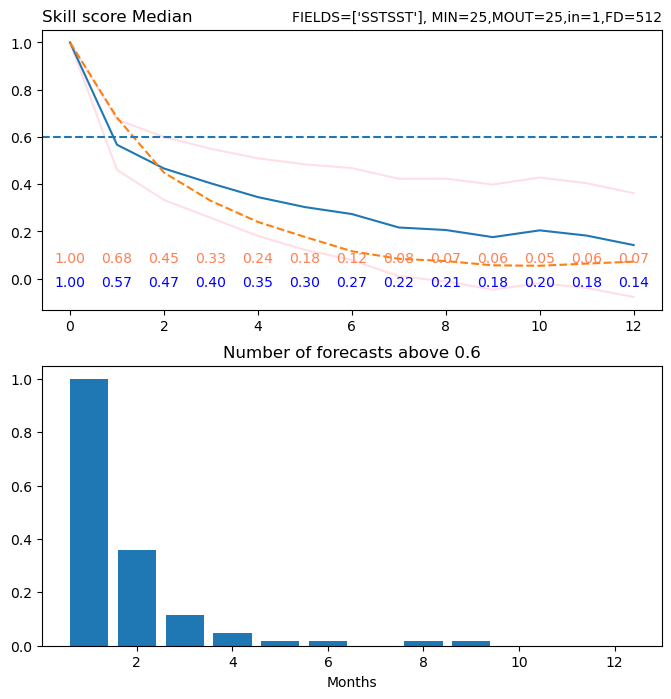

In [95]:


fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(8, 8))

# for i in range(1,Tpredict,5):
#     hl,=ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
#     ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Month {i}',color=hl.get_color(), linestyle='dashed')
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['HID_DIM']}"
    
# ax1.set_ylim(-0.4,1.2)
# ax1.set_title('Skill Score Median',loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
# ax1.legend()
skill='median'

tim = np.arange(0,Tpredict+1)

match skill:
    case 'mean':
        sk = np.mean(corrresult,axis=1)
        ps = np.mean(persistence,axis=1)
        if verify_dyn:
            dyn = np.mean(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,corrresult.mean(axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,corrresult.mean(axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case 'median':
        sk = np.median(corrresult,axis=1)
        ps = np.median(persistence,axis=1)
        if verify_dyn:
            dyn = np.median(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,np.median(corrresult,axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,np.median(corrresult,axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case _:
        raise ValueError('Invalid skill choice')
ax2.plot(tim,sk)
ax2.plot(tim,ps,linestyle='dashed')
if verify_dyn:
    ax2.plot(tim[1:7],dyn,linestyle='dashed',color='green')
        
ax2.axhline(0.6,linestyle='dashed')
ax2.set_title('Skill score Median',loc='left')
ax2.set_title(idfig,loc='right',fontsize=10)
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center',color='blue')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
    
tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')
ax3.set_xlabel('Months')
plt.savefig(f'FIG_{file}_{skill}.pdf')
plt.show()

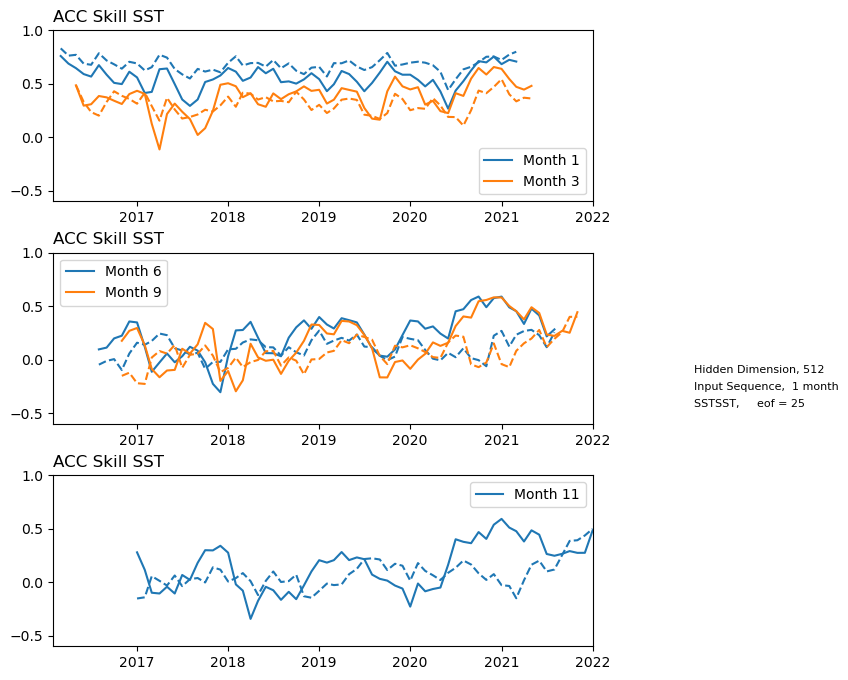

In [93]:
#Figure for forecast

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 2, width_ratios=[4, 1], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)

# Left panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Right panel, aligned with the middle left panel
ax4 = fig.add_subplot(gs[1, 1])

tit = f'ACC Skill {plfield[0:3]}'
if_time = [1,3]
col = ['black','red','lightblue', 'blue','green']

for i in if_time:
    hl,=ax1.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax1.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax1.set_ylim(-0.6,1.0)
ax1.set_title(tit,loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

if_time = [6,9]
for i in if_time:
    hl,=ax2.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax2.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax2.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax2.set_ylim(-0.6,1.0)
ax2.set_title(tit,loc='left')
# ax2.set_title(idfig,loc='right',fontsize=10)
ax2.legend()

if_time = [11]
for i in if_time:
    hl,=ax3.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax3.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax3.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax3.set_ylim(-0.6,1.0)
ax3.set_title(tit,loc='left')
# ax3.set_title(idfig,loc='right',fontsize=10)
ax3.legend()

# Remove the axis and labels for ax4
ax4.axis('off')  # This removes the axis lines and ticks
ax4.set_xticklabels([])  # This removes the x-axis labels
ax4.set_yticklabels([])  # This removes the y-axis labels

# Label the experiment
dfig = f"Predictors={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={N_LAYERS}"
delta = 0.0
ffcol = {'fontsize':8, 'color':'black'}
for ff in INX.keys():
    lab = f"{ff},     eof = {INX[ff]['mr']}"
    ax4.text(0, 0.1+delta, lab, **ffcol) 
    delta += 0.1
ax4.text(0, 0.2, f'Input Sequence,  {TIN} month', **ffcol) 
ax4.text(0, 0.3, f"Hidden Dimension, {params['HID_DIM']}", **ffcol) 

# Adjust layout
plt.tight_layout()
plt.savefig(f'FIG_{file}_Month.pdf')
plt.show()